# Question 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class BabyNames:
    
    def __init__(self):
        self.folder = None
        self.data = None
    
    def Constructor(self, file_location = None):
        
        # Create list of state abbreviations
        states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
        
        # Testing states
        #states = ["AL", "AK", "AZ", "AR", "CA", "CO"]
        
        # Init df
        df = pd.DataFrame()
        
        # Read all state babynames files into df
        for i in states:
            temp = pd.read_csv(file_location + "/" + str(i) + ".TXT", sep=",", header = None)
            df = pd.concat([df, temp])
        
        # Rename columns
        df = df.rename(columns={0: "state", 1: "sex", 2: "year", 3: "name", 4: "births"})
        
        # Store df in class
        self.data = df
        self.folder = file_location
        return self.data
    
    
    def Count(self, state = None, year = None):
        
        # Load class data
        df = self.data
        
        # Return sum births from df
        if state and year: return sum(df[(df.state == state) & (df.year == year)].births)

        elif not state and year: return sum(df[(df.year == year)].births)
            
        elif state and not year: return sum(df[(df.state == state)].births)
            
        else: return sum(df.births)
    
    def Top10BabyNames(self, state = "IL", year = 2015):
        
        # Load class data
        df = self.data
        
        # Get top ten names and ranks
        df_m = df[(df.state == state) & 
                  (df.year  == year) & 
                  (df.sex   == "M")].sort_values(by = 'births', ascending = False).head(10)
        
        df_f = df[(df.state == state) & 
                  (df.year  == year) & 
                  (df.sex   == "F")].sort_values(by = 'births', ascending = False).head(10).name
        
        df_m["ranks"]  = list(range(1, 11))
        df_m["name_f"] = list(df_f)
        
        # Return ranked table
        return df_m[["ranks", "name", "name_f"]]
    
    def ChangeOfPopularity(self, fromYear = 2014, toYear = 2015, top = 10):
        
        df = self.data
        
        # Get compare dataframe
        df = df[(df.year == fromYear) | (df.year == toYear)].groupby(["year", 
                                                                      "name"]).agg({"births": "sum"})
        df = df.reset_index()
        df_initial = df[df.year == fromYear]
        df_final   = df[df.year == toYear]
        
        df = pd.merge(df_initial, df_final, on = "name")
        df["change"] = df["births_y"] - df["births_x"] 
        
        # Get names that increased in popularity
        df_increased = df.sort_values(by = ["change"], ascending = False).head(top)
        
        # Get names that decreased in popularity
        df_decreased = df.sort_values(by = ["change"], ascending = True).head(top)
        dec_names, dec_by = list(df_decreased.name), list(df_decreased.change)
        
        # Get names that stayed the same in populatiry
        df_same = df.sort_values(by = ["change"], key = abs).head(top)
        same_names, same_by = list(df_same.name), list(df_same.change)
        
        # Create output table
        df_increased["ranks"]  = list(range(1, top+1))
        
        df_increased["dec_names"]  = dec_names
        df_increased["dec_by"]     = dec_by
        df_increased["same_names"] = same_names
        df_increased["same_by"]    = same_by
        
        df = df_increased[["ranks", "name", "change", 
                             "dec_names", "dec_by", 
                             "same_names", "same_by"]]
        
        df = df.rename(columns={"ranks": "Ranks", "name": "Inc. Names", 
                                "change": "Inc. Change", "dec_names": "Dec. Names", 
                                "dec_by": "Dec. Change", "same_names": "Same Names", 
                                "same_by": "Same Change"})
        
        return df
    
    def Top5NamesPerYear(self, year = 2015, sex = ''):
        # sex argument can only take 'F','M', or ''

        #filtering dataframe based on the given input
        if sex != '':
            df = self.data[(self.data['year'] == year) & (self.data['sex'] == sex)]
            df = df.groupby('state').head(5).reset_index(drop=True)
        else:
            df = self.data[(self.data['year'] == year)]
            g = df.groupby('state')
            df = g.apply(lambda x: x.sort_values(by = 'births', ascending=False).head(5))
        uniq_state = df['state'].unique()
        
        # number of rows the filtered dataframe
        num_rows = df.shape[0]
        ranks = [[],[],[],[],[]]
        nums = [[],[],[],[],[]]
        for i in range(num_rows):
            index = i%5
            ranks[index].append(df.iloc[i,3])
            nums[index].append(df.iloc[i,4])
            
        #construct an output dataframe
        if sex == 'F':
            psex = 'Female'
        elif sex == 'M':
            psex = 'Male'
        elif sex == '':
            psex = 'Female or Male'
        print("Top Five " + psex + " Names for Births in " + str(year))
        output_df = pd.DataFrame({'State': uniq_state,'Rank1': ranks[0],'Num1': nums[0], 'Rank2':ranks[1],
                            'Num2': nums[1], 'Rank3':ranks[2],'Num3': nums[2], 'Rank4':ranks[3],'Num4': nums[3],
                             'Rank5':ranks[4],'Num5': nums[4]})
        return output_df
        
    
    def NamePopularityPlot(self, name = "Jim", yearRange = (2000, 2015), state = "IL", sex = "M"):
        startY = yearRange[0]
        endY = yearRange[1]
        year_list = list(range(startY,endY))
        p_rawdata = self.data[(self.data['year']>= startY) & (self.data['year'] <=  endY)]
        p_rawdata = p_rawdata.pivot_table(index = ['name','state','sex'],columns = 'year',values = 'births')
        p_rawdata = p_rawdata[(p_rawdata.index.get_level_values(0) == name)&(p_rawdata.index.get_level_values(1) == state)&(p_rawdata.index.get_level_values(2) == sex)]
        p_rawdata = p_rawdata.transpose().fillna(0)
        graph = p_rawdata.plot()
        print(graph)
        return None
    
    def NameFlip(self, n = 10):
         # This function returns the top N names that has been flipped the most. 

        # group data by names and year, and shows the corresponding number of births for female and male
        pivoted_df = self.data.pivot_table(values = 'births', index = ['name','year'],columns = 'sex', aggfunc=np.sum)
        pivoted_df = pivoted_df.fillna(0)

        # 'F-M' column calculates the difference between number of females and males using the same name
        # a positive value of F-M indicates a girl name, a negative value of F-M indicates a boy name
        pivoted_df['F-M'] = pivoted_df['F'] - pivoted_df['M']

        # check if the name has been flipped, i.e, the sign of (F-M) is changed. 
        flip_df2 =  pd.DataFrame(pivoted_df.groupby('name')['F-M'].apply(lambda grp: max(grp)*min(grp)))
        flip_df2.columns = ['flip_or_not']
        # only filtering rows with changed signs in F-M columns
        flip_df2 = flip_df2[flip_df2['flip_or_not']<0]
        names_flipped = list(flip_df2.index)
        
        #calculte the number of flips, i.e. max('F-M')-min('F-M') for each name across time. 
        filter_flip = pivoted_df[pivoted_df.index.isin(names_flipped, level=0)]
        filter_flip = pd.DataFrame(filter_flip.groupby('name')['F-M'].apply(lambda grp: max(grp)-min(grp)))
        filter_flip.columns = ['max_flips']
        # sort names based on the 'Max_flips'
        filter_flip = filter_flip.sort_values(by = ['max_flips','name'], ascending = [False,True])
        
        #top n names filpped the most.
        names= list(filter_flip.index[0:n])
        # preparing a dataframe to be plotted latter
        plotted_df = pivoted_df[pivoted_df.index.isin(names, level=0)]
        plotted_df = pd.pivot_table(plotted_df, index = 'year', columns = 'name', values = 'F-M')
        #plotting a graph
        line_plot = plotted_df.plot(figsize=(12,10),grid=False,title='difference between number of females and male (F-M) for each top flipped names across time')
        line_plot.axhline (y=0 , color = 'black')

        # return a list of top n names filpped the most.
        return names

In [2]:
#baby_test = BabyNames().Constructor(file_location = r"C:\Users\nuke2\Desktop\NW Work\Data\babynames")
baby_test = BabyNames()
test_df = baby_test.Constructor(file_location = '../Project/namesbystate')
print(test_df)

      state sex  year      name  births
0        AL   F  1910      Mary     875
1        AL   F  1910     Annie     482
2        AL   F  1910    Willie     257
3        AL   F  1910    Mattie     232
4        AL   F  1910      Ruby     204
...     ...  ..   ...       ...     ...
28746    WY   M  2021  Santiago       5
28747    WY   M  2021   Spencer       5
28748    WY   M  2021      Tate       5
28749    WY   M  2021   Timothy       5
28750    WY   M  2021    Tucker       5

[6311504 rows x 5 columns]


In [3]:
baby_test.ChangeOfPopularity()


,Ranks,Inc. Names,Inc. Change,Dec. Names,Dec. Change,Same Names,Same Change
6098,1,Oliver,2219,Jayden,-1557,Bayler,0
382,2,Alexa,1794,Isabella,-1474,Rhylie,0
3238,3,Hazel,1396,Jase,-1455,Aydenn,0
5662,4,Mia,1394,Sophia,-1201,Skylan,0
3083,5,Grayson,1361,Joshua,-1100,Caylen,0
5521,6,Matteo,1356,Annabelle,-1084,Skylie,0
1758,7,Charlotte,1289,Andrew,-1046,Imogene,0
5507,8,Mateo,1279,Peyton,-1018,Leilanie,0
5035,9,Lincoln,1205,Michael,-1010,Sohan,0
6812,10,Scarlett,1129,Alexis,-1003,Jannet,0


In [4]:
# showing top 5 female names in 2015 by states
baby_test.Top5NamesPerYear(year = 2015, sex = 'F').head()


Top Five Female Names for Births in 2015


,State,Rank1,Num1,Rank2,Num2,Rank3,Num3,Rank4,Num4,Rank5,Num5
0,AL,Ava,298,Emma,287,Olivia,260,Harper,214,Elizabeth,187
1,AK,Olivia,56,Emma,49,Aurora,46,Ava,41,Amelia,39
2,AZ,Sophia,477,Mia,465,Emma,453,Olivia,422,Isabella,388
3,AR,Emma,214,Olivia,172,Ava,169,Isabella,136,Harper,121
4,CA,Sophia,2956,Mia,2866,Emma,2724,Olivia,2530,Isabella,2408


AxesSubplot(0.125,0.11;0.775x0.77)


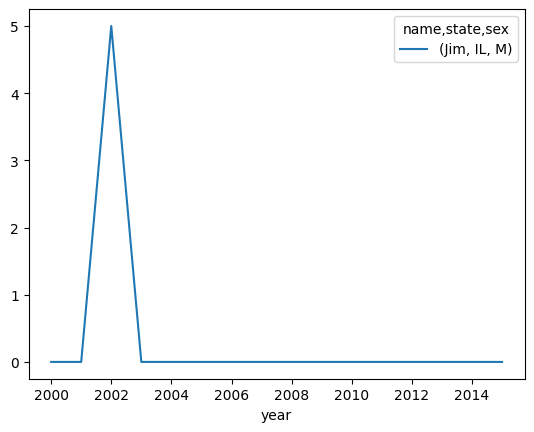

In [5]:
baby_test.NamePopularityPlot()


AxesSubplot(0.125,0.11;0.775x0.77)


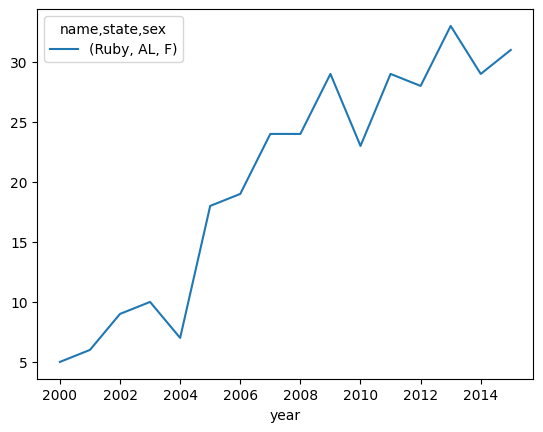

In [6]:
baby_test.NamePopularityPlot('Ruby',(2000,2015),state = 'AL', sex = 'F')

The following plot shows the top 10 names that have been flipped the most from 1910 to 2020. The line graph represents the difference between number of females and males (F-M) using the name. All lines in the graph go across the black line y = 0, indicating that names are flipped at least once. The graph shows that top 10 names are all flipped from a boy name to a girl name. 

['Ashley', 'Madison', 'Joan', 'Lauren', 'Alexis', 'Kelly', 'Tracy', 'Taylor', 'Courtney', 'Robin']


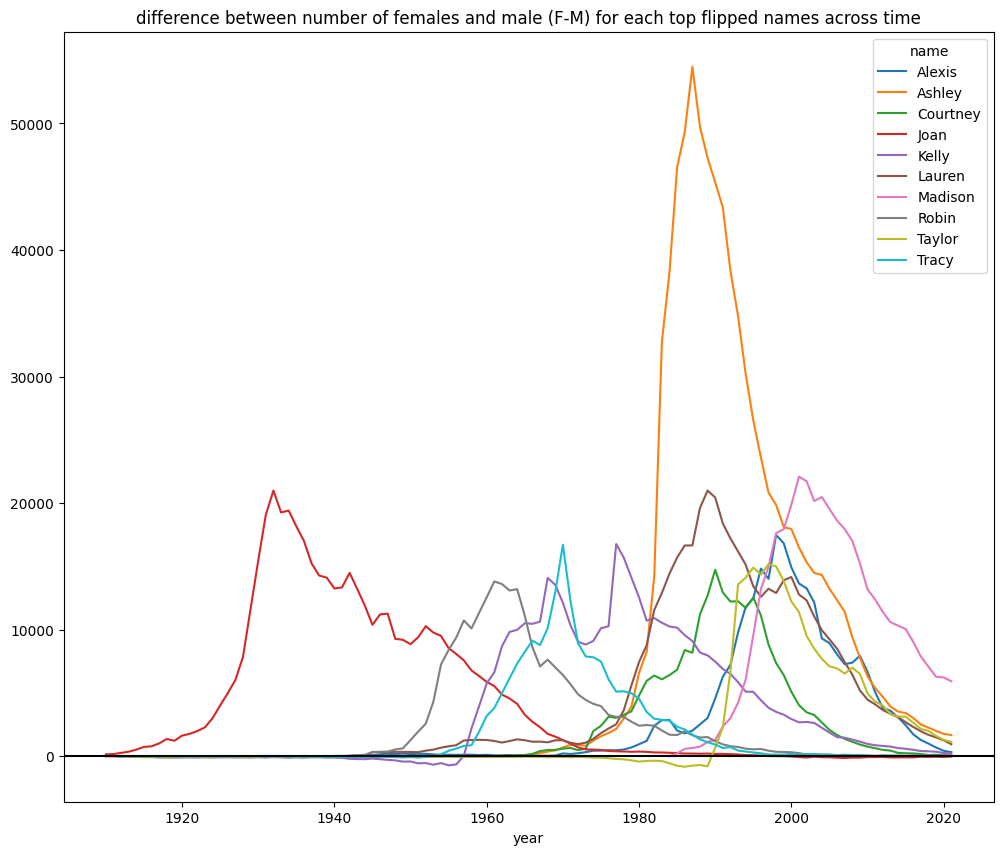

In [7]:
# defualt test caas
print(baby_test.NameFlip())


The following graph shows top 20 names that are flipped the most over time. Only one of top 20 names, Terry, is flipped from a girl name to a boy name. 

['Ashley', 'Madison', 'Joan', 'Lauren', 'Alexis', 'Kelly', 'Tracy', 'Taylor', 'Courtney', 'Robin', 'Jean', 'Kim', 'Addison', 'Kelsey', 'Michele', 'Shannon', 'Terry', 'Laurie', 'Harper', 'Jamie']


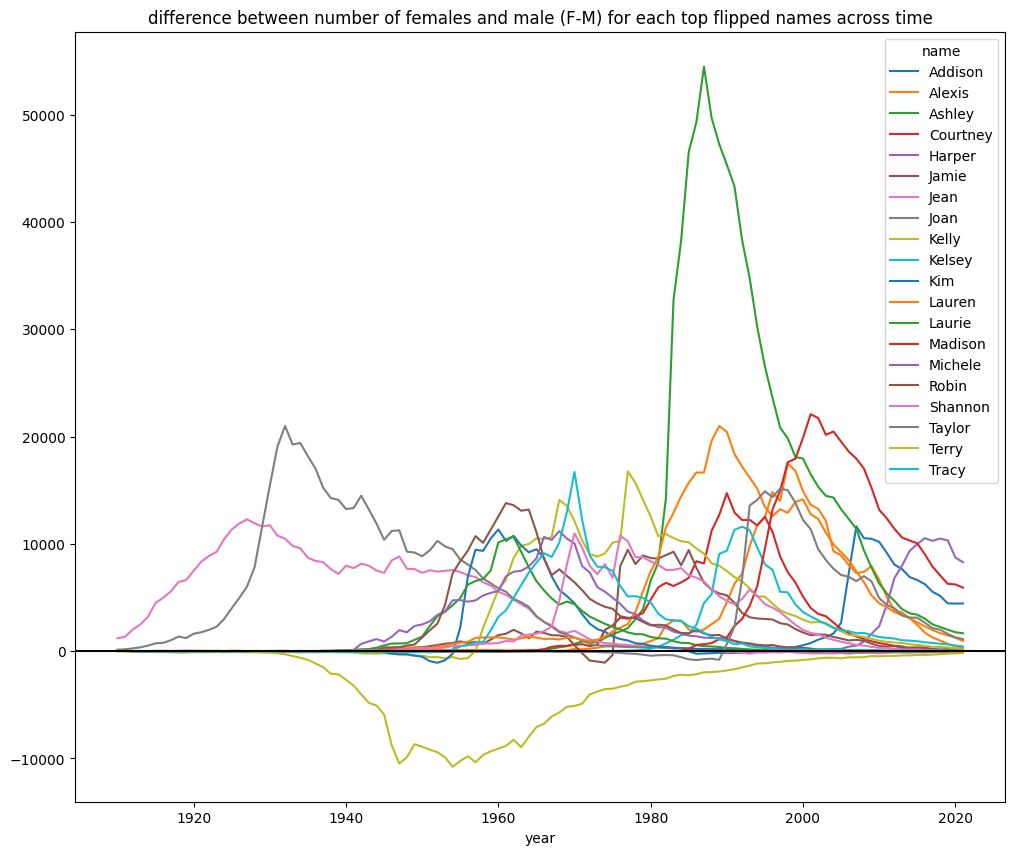

In [8]:
print(baby_test.NameFlip(20))


## Story Telling


Text(0, 0.5, 'Number of births in total')

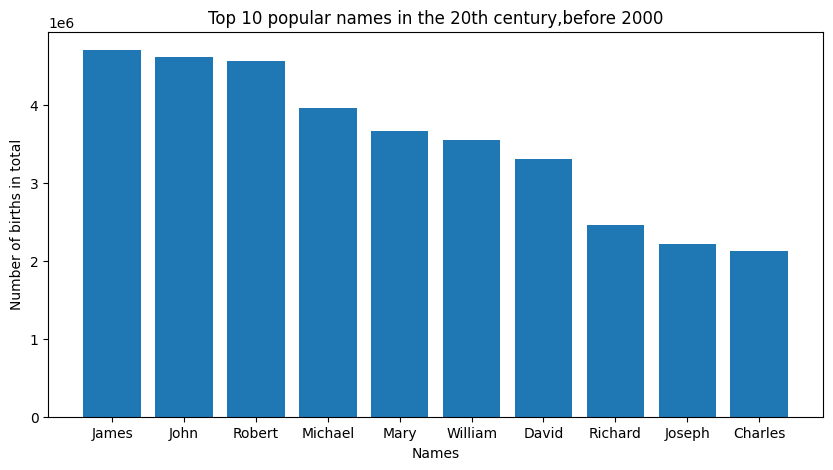

In [9]:
#popular names in the 20th century
name_90s= test_df[test_df['year'] < 2000]
name_90s = name_90s.groupby(['name','sex'])['births'].sum()
name_90s = name_90s.sort_values(ascending = False)
top10_90s = pd.DataFrame(name_90s.iloc[0:10,])
top10_90s.columns = ['births']
plt.figure(figsize = (10,5))
plt.bar(list(top10_90s.index.get_level_values(0)),list(top10_90s['births']))
plt.title("Top 10 popular names in the 20th century,before 2000")
plt.xlabel("Names")
plt.ylabel("Number of births in total")


A bar plot shows top 10 popular names in the US in the 20th century.

<AxesSubplot: title={'center': 'Proportion of males and females name among \n top 10 popular names in 20th century'}, ylabel='sex'>

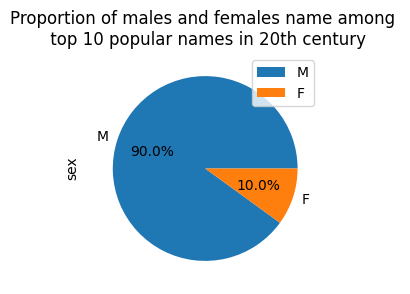

In [10]:
gender_ditr90 = top10_90s.index.get_level_values(1).value_counts()
gender_ditr90.plot.pie(title="Proportion of males and females name among \n top 10 popular names in 20th century",legend=True,autopct='%1.1f%%',figsize = (3,3))


Among top 10 popular names in the 20th century, only one of names is girls' name, and the rest nine names are all boy's name.


Text(0, 0.5, 'Number of births in total')

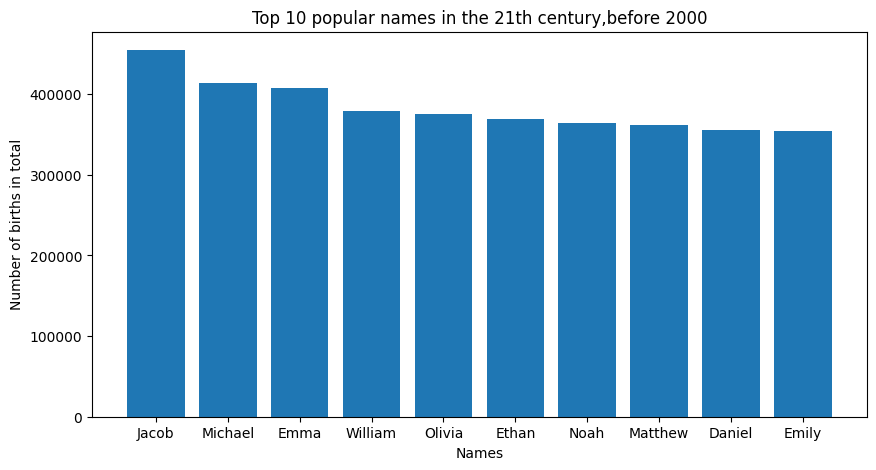

In [11]:
# popular names in the 21st century
name_00s= test_df[test_df['year'] >= 2000]
name_00s = name_00s.groupby(['name','sex'])['births'].sum()
name_00s = name_00s.sort_values(ascending = False)
top10_00s = pd.DataFrame(name_00s.iloc[0:10,])
top10_00s.columns = ['births']
plt.figure(figsize = (10,5))
plt.bar(list(top10_00s.index.get_level_values(0)),list(top10_00s['births']))
plt.title("Top 10 popular names in the 21th century,before 2000")
plt.xlabel("Names")
plt.ylabel("Number of births in total")



A bar plot shows top 10 popular names in the US in the 21th century.


<AxesSubplot: title={'center': 'Proportion of males and females name among \n top 10 popular names in 21th century'}, ylabel='sex'>

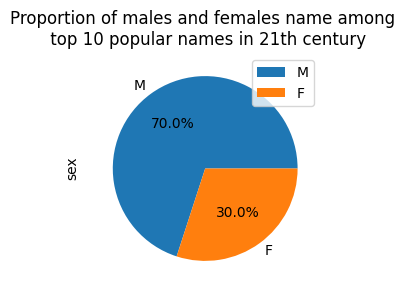

In [12]:
gender_ditr00 = top10_00s.index.get_level_values(1).value_counts()
gender_ditr00.plot.pie(title="Proportion of males and females name among \n top 10 popular names in 21th century",
                        legend=True,autopct='%1.1f%%',figsize = (3,3))
                        

Among top 10 popular names in the 21th century, the proportion of girl's name is increased from 10% to 30% compared in the 20th century. 


<AxesSubplot: xlabel='year'>

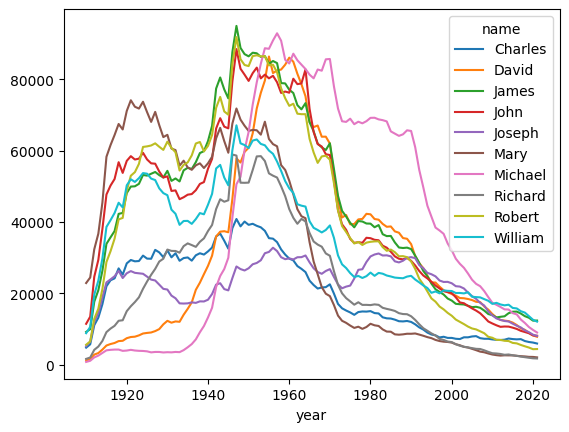

In [13]:
# See if names popular in the 20 century are still popular in the 21 century
popName90 = list(top10_90s.index.get_level_values(0))
trend_pop90 = test_df[test_df['name'].isin(popName90)]
trend_pop90 = trend_pop90.pivot_table(index = 'year',columns = 'name',values = 'births',aggfunc=np.sum)
trend_pop90.plot()


The line graph indicates a decreasing trend in popularity of names since 1980, indicating that names used to be popular in the 20th century become less popular in the 21th century

# Question 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymysql

cnx = pymysql.connect(user='root', \
      password='MSiA422PythonProject1!', \
      host= '127.0.0.1', \
      port=3306, \
      db='world', \
      autocommit=True)

## 1

This query is finding the top ten countries with a population of over 5 million.

In [2]:
country_sql = pd.read_sql_query(
    '''select *
    from Country
    where population > 50000000
    order by population DESC limit 10
    '''
    , con=cnx)

country_pandas = pd.read_sql_query(
    '''select *
    from Country
    '''
    , con=cnx)
country_pandas = country_pandas[country_pandas.Population > 50000000].sort_values(by = ["Population"], 
                                                                                  ascending = False).head(10)

country_sql == country_pandas.reset_index().iloc[: , 1:]

C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


## 2

This query is grouping each continent and summing the population. This results in a table that shows the ordered continents by population.

In [3]:
q2_sql = pd.read_sql_query(
    '''select Continent, count(*) As Number_Countries, sum(population) As Population
    from country
    where population > 0
    group by Continent
    order by 1 ASC 
    '''
    , con=cnx)

country_pandas = pd.read_sql_query(
    '''select *
    from country
    '''
    , con=cnx)

country_sql
country_pandas = country_pandas.groupby("Continent").agg({"Code": "count", 
                                                          "Population": "sum"}).reset_index()
country_pandas = country_pandas[country_pandas.Population > 0].sort_values(by = "Continent")
country_pandas = country_pandas.rename(columns={"Code": "Number_Countries"})
country_pandas = country_pandas.reset_index().iloc[:, 1:]
country_pandas

C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Continent,Number_Countries,Population
0,Africa,58,784475000
1,Asia,51,3705025700
2,Europe,46,730074600
3,North America,37,482993000
4,Oceania,28,30401150
5,South America,14,345780000


In [4]:
q2_sql

,Continent,Number_Countries,Population
0,Asia,51,3.705026e+09
1,Europe,46,7.300746e+08
2,North America,37,4.829930e+08
3,Africa,57,7.844750e+08
4,Oceania,27,3.040115e+07
5,South America,14,3.457800e+08


As we can see, the SQL server sorts differently than the pandas function. We however still have the same dataframes in terms of the content.

## 3

This query is outputting the top ten cities in the US that have the highest population

In [5]:
q3_sql = pd.read_sql_query(
    '''select city.Name As City, city.population
    from city
    inner join country ON city.CountryCode = country.code
    where country.code = 'USA'
    order by city.population DESC limit 10
    '''
    , con = cnx)

city_pandas = pd.read_sql_query(
    '''select *
    from city
    '''
    , con = cnx)

country_pandas = pd.read_sql_query(
    '''select *
    from country
    '''
    , con = cnx)

city_pandas = city_pandas.rename(columns={"CountryCode": "Code"})

df_3 = pd.merge(city_pandas, country_pandas, on = 'Code')
df_3 = df_3[df_3.Code == "USA"].sort_values(by="Population_x", ascending=False)

df_3 = df_3[["Name_x", "Population_x"]].head(10).reset_index().iloc[:, 1:].rename(columns={"Name_x": "City",
                                                                                    "Population_x": "population"})
q3_sql == df_3

C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,City,population
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
5,True,True
6,True,True
7,True,True
8,True,True
9,True,True


## 4

This query is calculating the percentage times population divided by 100 to get the number of people who speak one language in a country. It is then ordering it in descending order and limiting the output to ten to see the top ten languages in one country.

In [6]:
q4_sql = pd.read_sql_query(
    '''select country.Name, Language, (Percentage * population) / 100
    from countrylanguage
    inner join country on countrylanguage.CountryCode = country.code
    where IsOfficial = True
    order by 3 DESC limit 10
    '''
    , con = cnx)

country_language_pandas = pd.read_sql_query(
    '''select *
    from countrylanguage
    '''
    , con = cnx)
country_language_pandas = country_language_pandas.rename(columns={"CountryCode": "Code"})

country_pandas = pd.read_sql_query(
    '''select *
    from country
    '''
    , con = cnx)


df_4 = pd.merge(country_language_pandas, country_pandas, on = 'Code')

df_4["(Percentage * population) / 100"] = df_4.Percentage * df_4.Population / 100
df_4

df_4 = df_4[["Name", 
             "Language", 
             "(Percentage * population) / 100"]].sort_values(by = "(Percentage * population) / 100", 
                                                           ascending = False).head(10).reset_index().iloc[:, 1:]
df_4

C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044511e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Indonesia,Javanese,8.357016e+07
9,India,Bengali,8.312028e+07


In [7]:
q4_sql

,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044511e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


## 5

This query finds and groups the by languages. It sums the amount of people that speak it in all countries and then orders by that in decending order and limits the output to the top 5

In [8]:
q5_sql = pd.read_sql_query(
    '''select Language, sum((Percentage * population) / 100)
    from countrylanguage
    inner join country ON countrylanguage.CountryCode = country.code
    group by Language
    order by 2 desc limit 5
    '''
    , con = cnx)

country_language_pandas = pd.read_sql_query(
    '''select *
    from countrylanguage
    '''
    , con = cnx)
country_language_pandas = country_language_pandas.rename(columns={"CountryCode": "Code"})

country_pandas = pd.read_sql_query(
    '''select *
    from country
    '''
    , con = cnx)

df_5 = pd.merge(country_language_pandas, country_pandas, on = 'Code')

df_5["sum((Percentage * population) / 100)"] = df_5.Percentage * df_5.Population / 100
df_5 = df_5.groupby("Language").agg({"sum((Percentage * population) / 100)": "sum"})
df_5 = df_5.reset_index().sort_values(by = "sum((Percentage * population) / 100)", ascending = False).head(5).reset_index().iloc[:, 1:]
df_5 == q5_sql

C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\nuke2\miniconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Language,sum((Percentage * population) / 100)
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
